# Rozkład Nienormalny

![robot.png](https://live.staticflickr.com/65535/54430891765_38ef5cb61e_z.jpg)

*Obraz wygenrowany za pomocą ChatGPT.*

## Wstęp

Szum towarzyszy nam przynajmniej tak długo, jak długo rejestrujemy obserwacje wszelkiego rodzaju. Czy wynika to z faktu, że nie żyjemy w świecie klasycznych filozoficznych abstrakcji, czy może prawda jest o wiele bardziej prozaiczna—w kadr aparatu, obiektyw teleskopu, urywek tekstu czy nagranie dźwiękowe bardzo często dostają się zupełnie przez nas niepożądane sygnały, które—owszem—współtworzą rzeczywistość, lecz w momencie przeprowadzenia obserwacji wolelibyśmy ich uniknąć. W kontekście tego zadania, taką nadmiarową informację nałożoną na informację bazową (prawdziwą), będziemy nazywać szumem.

Szum rozważa się, a więc i opisuje matematycznie—w naukach ścisłych, szczególnie w tzw. *teorii informacji*. W grafice komputerowej szumem (*funkcją zaszumiającą*) nazwiemy f:

$$f: X → X$$

gdzie X to określona dziedzina zdjęć. Dla zdjęć o rozmiarze 28x28 w skali szarości zakodowanej w zakresie liczb rzeczywistych [0, 1]:

$$X = [0,1]^{28 * 28} $$

Sensownym założeniem jest, że f istotnie różni się od funkcji identycznościowej, tj. w istotny sposób zniekształca bazowe zdjęcie.

*Szum gaussowski* definiuje się na podstawie **rozkładu Gaussa**, o gęstości prawdopowodobieństwa zadanej wzorem:

$$f_{\mu, \sigma}(x) = \frac{1}{\sigma \sqrt{2π}}e^{\frac{-(x - \mu)^2}{2\sigma^2}}$$

**Rozkład Gaussa** jest parametryzowany przez dwie stałe: $\mu$ - *średnią* i $\sigma$ - *odchylenie standardowe* lub równoważnie: $\mu$ - *średnią* i $\sigma^2$ - *wariancję* (kwadrat odchylenia standardowego). Popularne biblioteki do obliczeń zawierają implementację *samplowania* próbek z tego rozkładu. By zaszumić obraz parametryzowanym rozkładem, próbkujemy z niego tablicę o rozmiarze równym rozmiarowi zdjęcia, dodajemy szum do zdjęcia (dodajemy *po pikselach*), po czym zapewniamy, by wartości pikseli pozostały w przedziale [0, 1] (funkcja **clamp**).

In [1]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

def add_normal_noise(image, mean=0, std=0.2):
    """Adds normal (Gaussian) noise to the image."""
    noise = torch.distributions.normal.Normal(mean, std)
    noise = noise.sample(image.size())
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0.0, 1.0)

**Rozkład jednostajny** ma prostą intuicję—określamy przedział $[a,b]$ i chcemy, by szanse wylosowania dowolnych dwóch różnych liczb z przedziału były takie same, natomiast dowolnej liczby spoza przedziału—zerowe. Formalnie, gęstość prawdopodobieństwa rozkładu jednostajnego określa wzór:

$$    
  f(x) =
  \begin{cases}
    \frac{1}{b-a}, & \text{for } a \leq x \leq b \\
    0
  \end{cases}
\
$$

Zaszumiając obrazek szumem jednostajnym, postępujemy analogicznie jak przy szumie gaussowskim. Losujemy próbkę z rozkładu, dodajemy ją do zdjęcia i ewentualne piksele wykraczające poza przedział $[0,1]$ ustawiamy na odpowiednie ograniczenie zakresu.

In [2]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

def add_uniform_noise(image, low=-0.5, high=0.5):
    """Adds uniform noise to the image."""
    noise = torch.empty(image.size()).uniform_(low, high)
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0.0, 1.0)

## Zadanie

Wyobraź sobie, że jesteś specjalistą ds. przetwarzania obrazu w firmie zajmującej się analizą i rekonstrukcją obrazów. Twój zespół pracuje nad systemem, który potrafi nie tylko usuwać szum z obrazów, ale również identyfikować jego rodzaj i parametry, co może dostarczyć cennych informacji o źródle zakłóceń.

Twoim zadaniem jest zaprojektowanie i wytrenowanie pojedynczej architektury sieci neuronowej, która będzie w stanie jednocześnie realizować trzy cele:

- **Odszumianie obrazów** - przywracanie oryginalnego wyglądu zdjęć zaszumionych jednym z dwóch rodzajów szumów: gaussowskim albo jednostajnym;
- **Klasyfikacja typu szumu** - określenie, czy zdjęcie zostało zaszumione szumem gaussowskim (etykieta 0) czy jednostajnym (etykieta 1);
- **Estymacja parametrów szumu gaussowskiego** - dla zdjęć zaszumionych szumem gaussowskim, model powinien dodatkowo estymować parametry tego szumu: średnią $\mu$ i odchylenie standardowe $\sigma$

**Zwróć uwagę, że każde poszczególne zdjęcie zostało zaszumione losowo wybranym rozkładem z losowo wybranymi (potencjalnie różnymi na całym zbiorze danych) parametrami.**

### Dane
Dostępne dla Ciebie w tym zadaniu dane to:

- **Zbiór danych treningowych**, zawierający zarówno obrazy oryginalne, jak i ich zaszumione wersje wraz z etykietami rodzaju szumu
- **Zbiór danych walidacyjnych**, który pomoże Ci ocenić jakość Twojego modelu w trakcie treningu

Przygotowaliśmy dla Ciebie dataloader. W zbiorze treningowym, każdy przykład składa się z:

- Zdjęcia przed zaszumieniem - klucz `['original']`
- Zdjęcia po zaszumieniu - klucz `['noised']`
- Etykiety rodzaju szumu - klucz `['label']`
- Parametrów szumu - klucz `['params']` (dostępne tylko dla zbioru walidacyjnego i testowego)

Poniższa grafika ilustruje przykładowy proces powstawania zaszumionych zdjęć dla obu szumów parametryzowanych przykładowymi argumentami.

![noise_schema.png](https://live.staticflickr.com/65535/54429663172_1014ff20d7_z.jpg")

Twoje rozwiązanie zostanie ostatecznie przetestowane na Platformie Konkursowej na ukrytym zestawie danych testowych, który jest zbalansowany pod względem typów szumów, a obrazki w nim cechują się takimi samymi charakterystykami, jak te dostarczone uczestnikom.


### Kryterium Oceny

Jak możesz się spodziewać, w ewaluacji będziemy oceniać cztery kluczowe aspekty Twojego rozwiązania:

1. **Dokładność klasyfikacji binarnej szumu** (waga 25%) - jak skutecznie model rozpoznaje rodzaj szumu:

$$    
  accuracyScore =
  \begin{cases}
    \frac{accuracy - 0.5}{0.45}, & \text{dla } 0.5 < accuracy < 0.95 \\
    0.0, & \text{dla } accuracy \leq 0.5 \\
    1.0, & \text{dla } 0.95 \leq accuracy
  \end{cases}
\
$$

2. **Jakość rekonstrukcji obrazu** (waga 25%) - mierzona metryką PSNR (Peak Signal-to-Noise Ratio):

$$    
  psnrScore =
  \begin{cases}
    \frac{PSNR - 10}{6}, & \text{dla } 10 < PSNR < 16 \\
    0.0, & \text{dla } PSNR \leq 10 \\
    1.0, & \text{dla } 16 \leq PSNR
  \end{cases}
\
$$

gdzie PSNR jest zdefiniowane jako:

$$PSNR = 10 log_{10}\frac{MAX_{I}^{2}}{MSE},$$

gdzie $MAX_{I}$ to maksymalna możliwa wartość piksela przy zadanej reprezentacji i w naszym przypadku $MAX_{I} = 1$.


3. **Dokładność estymacji parametru średniej $\mu$ szumu gaussowskiego** (waga 25%) - mierzona błędem średniokwadratowym (MSE) i liczona po elementach zbioru testowego z etykietą 0 (szum *gaussowski*):

$$    
  meanMseScore =
  \begin{cases}
   1.0, & \text{dla } MSE < 0.005 \\
   0.0, & \text {w przeciwnym przypadku}
  \end{cases}
\
$$

4. **Dokładność estymacji parametru odchylenia standardowego $\sigma$ szumu gaussowskiego** (waga 25%) - również mierzona błędem średniokwadratowym (MSE) i liczona po elementach zbioru testowego z etykietą 0 (szum *gaussowski*):

$$    
  stdMseScore =
  \begin{cases}
   1.0, & \text{dla } MSE < 0.005 \\
   0.0, & \text {w przeciwnym przypadku}
  \end{cases}
\
$$

**Ostateczna Formuła Oceny**

Końcowa ocena jest ważoną sumą powyższych metryk zgodnie ze wzorem:
$$ finalScore = 25 \cdot accuracyScore + 25 \cdot psnrScore + 25 \cdot meanMseScore + 25 \cdot stdMseScore $$

Za to zadanie możesz zdobyć od 0 do 100 punktów, gdzie:

- Wartości bliskie 0 wskazują na słabe rozwiązanie;
- Wartości bliskie 100 wskazują na doskonałe rozwiązanie, które skutecznie klasyfikuje rodzaj szumu, rekonstruuje oryginalne obrazy i precyzyjnie estymuje parametry szumu gaussowskiego.

## Ograniczenia

- Do uczenia modelu możesz używać jedynie zbioru treningowego.
- Twoje rozwiazanie będzie testowane na Platformie Konkursowej bez dostępu do internetu oraz w środowisku z GPU.
- Ewaluacja Twojego finalnego rozwiązania na Platformie Konkursowej nie może trwać dłużej niż 5 minut z GPU.

## Pliki zgłoszeniowe

Ten notebook uzupełniony o Twoje rozwiązanie (patrz klasa `Model`).

# Kod Startowy
W tej sekcji inicjalizujemy środowisko poprzez zaimportowanie potrzebnych bibliotek i funkcji. Przygotowany kod ułatwi Tobie efektywne operowanie na danych i budowanie właściwego rozwiązania.

In [3]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

FINAL_EVALUATION_MODE = False  # Podczas sprawdzania ustawimy tą flagę na True.

In [4]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

import os
import pickle
import random
from typing import Dict, List, Tuple
from collections.abc import Callable
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

assert torch.cuda.is_available(), "CUDA niedostępna!"

print("Device:", DEVICE)

Device: cuda


In [5]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

seed = 42

os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Komórka zawierająca funkcje pomocnicze do wizualiacji wyników

def plot_samples(dataset: Dataset, num_images: int = 6, title: str = "") -> None:
    """
    Funkcja do wyświetlania przykładów obrazów oryginalnych oraz zaszumionych

    Przyjmuje:
        dataset (Dataset): Zbiór danych.
        num_images (int): Liczba obrazów do wyświetlenia.
    """
    fig, axs = plt.subplots(2, num_images, figsize=(2 * num_images, 4))
    fig.suptitle(title, fontsize=10)

    for i in range(num_images):
        sample = dataset[i]
        original_image = sample["original"]
        noised_image = sample["noised"]
        label = sample["label"]
        params = sample.get("params", None)

        column_title = f"Przykład {i+1}\nEtykieta: {label.item():.0f}"

        if params is not None:
            if label.item() == 0:
                column_title += f"\nμ: {params[0].item():.2f}\nσ: {params[1].item():.2f}"
            else:
                column_title += f"\nlow: {params[0].item():.2f}\nhigh: {params[1].item():.2f}"
        else:
            if label.item() == 0:
                column_title += "\nμ: Brak\nσ: Brak"
            else:
                column_title += "\nlow: Brak\nhigh: Brak"

        column_title += "\n\nOryginalny"

        axs[0, i].set_title(column_title, fontsize=8, pad=5)
        axs[0, i].imshow(original_image.squeeze(), cmap="gray")
        axs[0, i].axis("off")

        axs[1, i].set_title("Zaszumiony", fontsize=8, pad=5)
        axs[1, i].imshow(noised_image.squeeze(), cmap="gray")
        axs[1, i].axis("off")

    plt.tight_layout()
    plt.show()


def plot_results(model: nn.Module, examples: Dict, num_images: int = 6) -> None:
    """
    Funkcja do wyświetlania przykładów obrazu zaszumionego oraz odszumionego przez model

    Przyjmuje:
        model (nn.Module): Model do odszumiania obrazów.
        examples (dict): Słownik zawierający przykłady obrazów.
        num_images (int): Liczba obrazów do wyświetlenia.
    """
    model.eval()
    noisy_images = examples["noised"][:num_images].to(DEVICE)
    clean_images = examples["original"][:num_images]
    label = examples["label"][:num_images]
    params = examples["params"][:num_images]
    mean_real = params[:, 0].view(-1, 1)
    std_real = params[:, 1].view(-1, 1)

    with torch.no_grad():
        output_images, predictions, mean_pred, std_pred = model(noisy_images.to(DEVICE))

    fig, axs = plt.subplots(3, num_images, figsize=(2 * num_images, 6))

    for i in range(num_images):
        column_title = (
            f"Przykład {i+1}\n"
            f"Etykieta: {float(predictions[i].item() > 0.5):.0f}/{label[i].item():.0f}\n"
        )

        if label[i].item() == 0:
            column_title += (
                f"μ: {mean_pred[i].item():.2f}/{mean_real[i].item():.2f}\n"
                f"σ: {std_pred[i].item():.2f}/{std_real[i].item():.2f}\n"
            )
        else:
            column_title += "\n\n"

        column_title += "\nZaszumiony"

        axs[0, i].set_title(column_title, fontsize=8, pad=5)
        axs[0, i].imshow(noisy_images[i].cpu().squeeze(), cmap="gray")
        axs[0, i].axis("off")

        axs[1, i].set_title("Odszumiony", fontsize=8, pad=5)
        axs[1, i].imshow(output_images[i].cpu().squeeze(), cmap="gray")
        axs[1, i].axis("off")

        axs[2, i].set_title("Oryginalny", fontsize=8, pad=5)
        axs[2, i].imshow(clean_images[i].squeeze(), cmap="gray")
        axs[2, i].axis("off")

    fig.text(0.5, 0.01, "Format: Predykcja/Etykieta", ha='center', fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.1)
    plt.show()


## Ładowanie Danych
Za pomocą poniższego kodu dane zostaną wczytane i odpowiednio przygotowane.

In [7]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Komórka zawierająca funkcje pomocnicze do przygotowania danych.

class NoisedDataset(Dataset):
    """
    Zbiór danych wczytywany z pliku pickle.

    Przyjmuje:
        file_path (str): Ścieżka do pliku pickle zawierającego dane.
        transform (callable, opcjonalnie): Transformacje stosowane do obrazów i etykiet.
    """
    def __init__(self, pickle_file, transform=None):
        self.transform = transform

        with open(pickle_file, 'rb') as f:
            self.data = pickle.load(f)

        self.has_params = 'params' in self.data[0]

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        sample = self.data[idx]
        original_image = sample['original']
        noised_image = sample['noised']
        label = sample['label']

        if self.has_params:
            data = {'params': sample['params']}
        else:
            data = {}

        if self.transform:
            original_image = self.transform(original_image)
            noised_image = self.transform(noised_image)

        data.update({
            'original': original_image,
            'noised': noised_image,
            'label': label
        })

        return data


def setup_data(
        train_transform: Callable | None = None,
        val_transform: Callable | None = None,
        root: str = './'
    ) -> Tuple[Dataset, Dataset]:
    """
    Przygotowuje zbiory danych do trenowania i walidacji, pobierając je jeśli to konieczne.

    Przyjmuje:
        train_transform (callable, opcjonalnie): Augmentacje dla zbioru treningowego.
        val_transform (callable, opcjonalnie): Augmentacje dla zbioru walidacyjnego.
        root (str, opcjonalnie): Katalog bazowy dla plików z danymi.

    Zwraca:
        tuple: Zbiory danych (train_ds, val_ds).
    """
    if train_transform is None:
        train_transform = transforms.Compose([transforms.ToTensor()])
    if val_transform is None:
        val_transform = transforms.Compose([transforms.ToTensor()])

    train_file = root+'train.pkl'
    val_file = root+'val.pkl'

    if not os.path.exists(root):
        os.makedirs(root)

    train_ds = NoisedDataset(train_file, transform=train_transform)
    val_ds = NoisedDataset(val_file, transform=val_transform)

    return train_ds, val_ds

Liczba zdjęć w zbiorze treningowym: 30000 , liczba zdjęć w zbiorze walidacyjnym: 2000


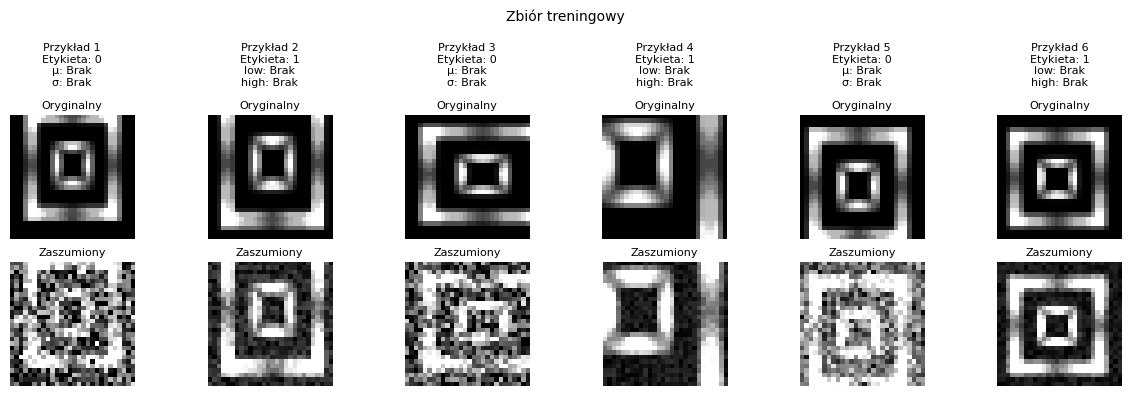

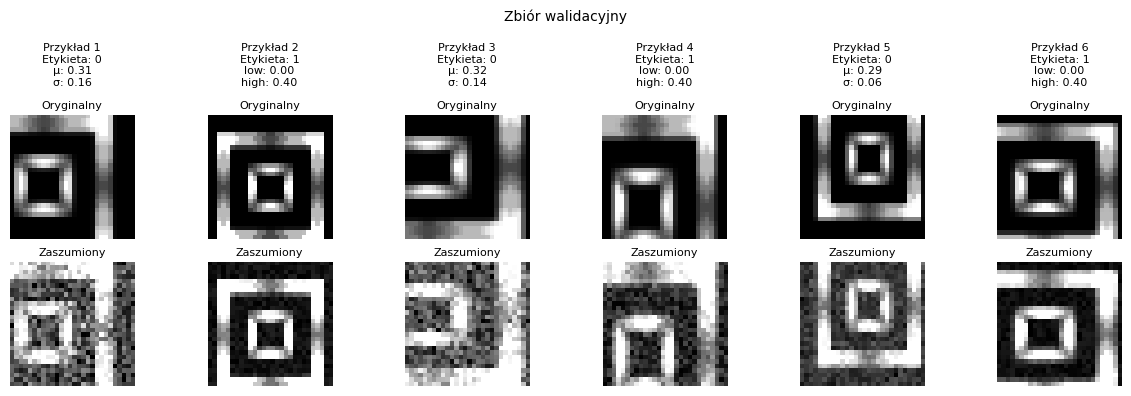

In [8]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

train_ds, val_ds = setup_data(root="./")

if not FINAL_EVALUATION_MODE:
    print("Liczba zdjęć w zbiorze treningowym:", len(train_ds), ", liczba zdjęć w zbiorze walidacyjnym:", len(val_ds))
    plot_samples(train_ds, num_images=6, title="Zbiór treningowy")
    plot_samples(val_ds, num_images=6, title="Zbiór walidacyjny")

## Kod z Kryterium Oceniającym
Kod, zbliżony do poniższego, będzie używany do oceny rozwiązania na zbiorze testowym.

In [9]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Komórka zawierająca funkcje pomocnicze do obliczenia wartości metryk modelu

def compute_psnr(input_image: torch.Tensor, target_image: torch.Tensor) -> torch.Tensor:
    """
    Funkcja obliczająca PSNR pomiędzy dwoma obrazami.

    Przyjmuje:
        input_image (torch.Tensor): Pierwszy obraz.
        target_image (torch.Tensor): Drugi obraz.

    Zwraca:
        torch.Tensor: Wartość PSNR.
    """
    mse = F.mse_loss(input_image, target_image)
    if mse == 0:
        return 100
    return 10 * torch.log10(1 / mse)

def model_eval(model: nn.Module, dataloader: DataLoader, device: str = DEVICE) -> Tuple[float, float, float, float]:
    """"
    Funkcja do ewaluacji modelu na zbiorze danych.

    Przyjmuje:
        model (nn.Module): Model do ewaluacji.
        dataloader (DataLoader): DataLoader z danymi do ewaluacji.
        device (str, opcjonalnie): Urządzenie, na którym ma być przeprowadzona ewaluacja.

    Zwraca:
        tuple: Krotka zawierająca wartości metryk (PSNR, dokładność, MSE dla parametru 1, MSE dla parametru 2).
    """
    model.eval()
    model.to(device)

    # Inicjalizacja zmiennych do przechowywania wyników
    psnr = 0
    correct = 0
    mean_mse = 0
    std_mse = 0

    total_samples = 0
    total_label0_samples = 0

    with torch.no_grad():
        for data in dataloader:
            noised_images = data["noised"].to(device)
            original_images = data["original"].to(device)
            labels = data["label"].to(device)
            params = data["params"].to(device)
            batch_size = len(labels)

            mean_real = params[:, 0].view(-1, 1)
            std_real = params[:, 1].view(-1, 1)

            output_images, labels_pred, mean_pred, std_pred = model(noised_images)

            # Obliczanie dokładności klasyfikacji
            correct += ((labels_pred >= 0.5).float().view(-1) == labels).sum().item()

            # Obliczanie PSNR
            psnr += compute_psnr(output_images, original_images) * batch_size

            # Obliczanie MSE dla parametrów, gdy etykieta wynosi 0
            label0_mask = (labels == 0)
            num_label0 = label0_mask.sum().item()

            if num_label0 > 0:
                mean_mse += F.mse_loss(mean_pred[label0_mask], mean_real[label0_mask], reduction='sum')
                std_mse += F.mse_loss(std_pred[label0_mask], std_real[label0_mask], reduction='sum')

            total_samples += batch_size
            total_label0_samples += num_label0

    # Obliczanie średnich wartości metryk
    psnr /= total_samples
    accuracy = correct / total_samples
    mean_mse /= total_label0_samples
    std_mse /= total_label0_samples

    return psnr.item(), accuracy, mean_mse.item(), std_mse.item()

In [10]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
# Komórka zawierająca funkcje pomocnicze do oceniania Twojego rozwiązania

def calculate_score(
    psnr: float, accuracy: float, mean_mse: float, std_mse: float
) -> Tuple[float, float, float, float]:
    """
    Funkcja obliczająca punkty za zadanie na podstawie metryk modelu.

    Przyjmuje:
        psnr (float): Wartość PSNR.
        accuracy (float): Dokładność klasyfikacji.
        mean_mse (float): MSE dla parametru 1.
        std_mse (float): MSE dla parametru 2.

    Zwraca:
        tuple: Krotka zawierająca punkty za zadanie (PSNR, dokładność, MSE dla parametru 1, MSE dla parametru 2).
    """

    def scale(x, lower=0.0, upper=1.0, max_points=1.0):
        scaled = min(max(x, lower), upper)
        return (scaled - lower) / (upper - lower) * max_points

    accuracy_score = scale(accuracy, lower=0.5, upper=0.95)
    psnr_score = scale(psnr, lower=10.0, upper=16.0)

    mean_score = 0.0
    if mean_mse < 0.005:
        mean_score = 1.0

    std_score = 0.0
    if std_mse < 0.005:
        std_score = 1.0

    return psnr_score, accuracy_score, mean_score, std_score


def grade_solution(model: nn.Module, dataloader: DataLoader) -> float:
    """
    Funkcja oceniająca model na zbiorze walidacyjnym.

    Przyjmuje:
        model (nn.Module): Model do oceny.
        dataloader (DataLoader): DataLoader z danymi do oceny.

    Zwraca:
        float: Liczba punktów za zadanie.
    """
    psnr, accuracy, mean_mse, std_mse = model_eval(model, dataloader)
    psnr_score, accuracy_score, mean_score, std_score = calculate_score(
        psnr, accuracy, mean_mse, std_mse
    )
    score = round(
        psnr_score * 25 + accuracy_score * 25 + mean_score * 25 + std_score * 25
    )

    # Zaokrąglenie do liczby całkowitej, przedział [0, 100]
    score = round(score)

    print(
        f"Metryki na zbiorze walidacyjnym\n"
        f"psnr: {psnr:.2f}, accuracy: {accuracy:.2f}, mean_mse: {mean_mse:.6f}, std_mse: {std_mse:.6f}\n"
    )
    print(
        f"Punkty częściowe za zadanie\n"
        f"psnr: {(psnr_score * 25):.2f}, accuracy: {(accuracy_score * 25):.2f}, mean_mse: {(mean_score * 25):.2f}, std_mse: {(std_score * 25):.2f}\n"
    )
    print(f"Estymowana liczba punktów za zadanie: {score}")
    return score


# Twoje Rozwiązanie
W tej sekcji należy umieścić Twoje rozwiązanie. Wprowadzaj zmiany wyłącznie tutaj!

In [11]:
# definicje augmentacji dla zbioru treningowego i walidacyjnego. Domyślnie None oznacza brak augmentacji
train_transform = None
val_transform = None

# rozmiar batcha
BATCH_SIZE: int = 64

train_ds, val_ds = setup_data(train_transform, val_transform, root="./")

In [12]:
# tutaj stwórz i wytrenuj Twój model

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  # Input: 1 channel (grayscale)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 7 * 7, 1000)  # Adjust input size based on pooling
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(1000, 28*28*1) # Output: single channel image 28x28
        
        self.fc3 = nn.Linear(1000, 1)
        self.fc4 = nn.Linear(1000, 1)
        self.fc5 = nn.Linear(1000, 1)

    def forward(self, inpt):
        x = self.conv1(inpt)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten for the fully connected layers
        x = self.fc1(x)
        features = self.relu3(x)
        
        x = self.fc2(features)
        x = x.view(-1, 1, 28, 28)
        
        classification = self.fc3(features)
        
        mean = self.fc4(features)
        std = self.fc5(features)
        
#         mean = torch.mean(x - inpt, dim=(1,2,3))
#         std = torch.std(x - inpt, dim=(1,2,3))

        device = x.device
        return (
            x,
            classification,  # Dummy classification prediction
            mean,
            std
        )

def train_model(train_dataset, valid_dataset, learning_rate=0.001, batch_size=32, num_epochs=10) -> Model:
    """Stwórz i wytrenuj model"""
    model = Model().to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    criterion = nn.MSELoss()  # Mean Squared Error for pixel-wise noise prediction
    class_criterion = nn.BCEWithLogitsLoss()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, batch in enumerate(train_dataloader):
            original_images = batch['original'].to(DEVICE)
            noised_images = batch['noised'].to(DEVICE)
            noised_images = batch['noised'].to(DEVICE)
            label = batch['label'].unsqueeze(1).to(DEVICE)
            mean, std = torch.mean(noised_images - original_images, dim=(1, 2, 3)).unsqueeze(1), torch.std(noised_images - original_images, dim=(1, 2, 3)).unsqueeze(1)
            
            # print(label.shape)
            # print(mean.shape)
            # print(std.shape)
            
            optimizer.zero_grad()
            predicted_noise, pred_class, pred_mean, pred_std = model(noised_images)  # Only the noise prediction is used
            
            # print(pred_class.shape)
            # print(pred_mean.shape)
            # print(pred_std.shape)
            # print("==============")
            
            loss = criterion(predicted_noise, original_images) + class_criterion(pred_class,label)
            mask = (label.flatten() == 0)
            loss += criterion(pred_mean[mask], mean[mask]) + criterion(pred_std[mask], std[mask])
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # if batch_idx % 100 == 0:
                # print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / len(train_dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}')

        # Validation
#         model.eval()
#         valid_loss = 0.0
#         val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

#         if not FINAL_EVALUATION_MODE:
#             grade_solution(model, val_dataloader)
#             examples = next(iter(val_dataloader))

    model.eval()
    return model


your_model = train_model(train_ds, val_ds, num_epochs=7)

Epoch [1/7], Average Train Loss: 0.2945
Epoch [2/7], Average Train Loss: 0.1632
Epoch [3/7], Average Train Loss: 0.1392
Epoch [4/7], Average Train Loss: 0.1213
Epoch [5/7], Average Train Loss: 0.1162
Epoch [6/7], Average Train Loss: 0.1102
Epoch [7/7], Average Train Loss: 0.1000


# Ewaluacja
Uruchomienie poniższej komórki pozwoli sprawdzić, ile punktów zdobyłoby Twoje rozwiązanie na danych walidacyjnych. Przed wysłaniem upewnij się, że cały notebook wykonuje się od początku do końca bez błędów i bez konieczności ingerencji użytkownika po wybraniu opcji "Run All".

Metryki na zbiorze walidacyjnym
psnr: 16.80, accuracy: 0.96, mean_mse: 0.001480, std_mse: 0.001644

Punkty częściowe za zadanie
psnr: 25.00, accuracy: 25.00, mean_mse: 25.00, std_mse: 25.00

Estymowana liczba punktów za zadanie: 100


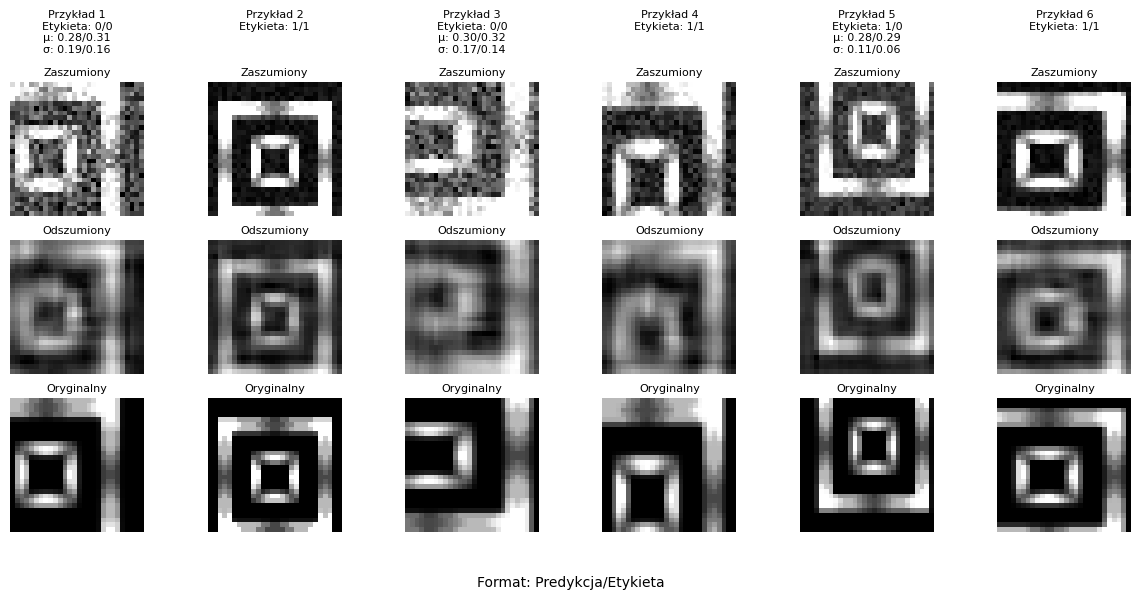

In [13]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

if not FINAL_EVALUATION_MODE:
    grade_solution(your_model, val_dataloader)
    examples = next(iter(val_dataloader))
    plot_results(your_model, examples, num_images=6)

Podczas sprawdzania model zostanie zapisany jako `your_model.pkl` i oceniony na zbiorze testowym.

In [14]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

if FINAL_EVALUATION_MODE:
    import cloudpickle

    # Gdy model posiada parametry, ustaw go w trybie ewaluacji i przenieś na CPU
    if list(your_model.parameters()):
        your_model.eval()
        your_model.cpu()

    OUTPUT_PATH = "file_output"
    FUNCTION_FILENAME = "your_model.pkl"
    FUNCTION_OUTPUT_PATH = os.path.join(OUTPUT_PATH, FUNCTION_FILENAME)

    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    with open(FUNCTION_OUTPUT_PATH, "wb") as f:
        cloudpickle.dump(your_model, f)